<a href="https://colab.research.google.com/github/juankuntz/ParEM/blob/main/torch/notebooks/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You can comment out the colab setup / local setup depending on where you want to run the code.

## Colab setup

Installs and imports the necessary modules. Variables of interest:

* `DATASET_PATH`: The directory of the dataset to be loaded or downloaded.
* `CHECKPOINTS_PATH`: The directory where the checkpoints will be saved.

In [1]:
%%capture
# Set paths
from google.colab import drive
drive.mount("/content/gdrive", force_remount=False) # Mount drive to VM in colab
DATASET_PATH = '/content/ParEM/datasets/MNIST'
CHECKPOINTS_PATH = '/content/gdrive/MyDrive/ParEM/checkpoints'

# Install missing packages
!pip install torchtyping
!pip install torchmetrics[image]
!pip install wandb

# Import standard modules
import sys

# Import custom modules
!rm -rf ParEM
!git clone https://github.com/juankuntz/ParEM.git
REPOSITORY_PATH = '/content/ParEM/torch'
if REPOSITORY_PATH not in sys.path:
    sys.path.append(REPOSITORY_PATH)

## Local setup

Variables of interest:

* `DATASET_PATH`: The directory of the dataset to be loaded or downloaded.
* `CHECKPOINTS_PATH`: The directory where the checkpoints will be saved.

In [2]:
# # Import standard modules
# import sys

# sys.path.append("../")

# DATASET_PATH = '../datasets/MNIST'
# CHECKPOINTS_PATH = '../checkpoints'

## General setup

In [3]:
# Import standard modules
import torch
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Import custom modules
from parem.models import NLVM
from parem.algorithms import (PGD,
                              ShortRun,
                              VI,
                              AlternatingBackprop)
from parem.utils import get_mnist, load_checkpoint

# Set config variables

In [4]:
# Data setttings
N_IMAGES = 10000  # M: training set size 

# Training settings
N_BATCH = 128 # M_b: batch size for theta updates
N_EPOCHS = 100 # n_epochs = K * M_b / M where K = total number of iterations
SEED = 1 # Seed for PRNG
# Device on which to carry out computations:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OPTIMIZER = 'rmsprop'  # Theta optimizer

# Model Settings
X_DIM = 64  # d_x: dimension of latent space
LIKELIHOOD_VAR = 0.01 ** 2  # sigma^2

# PGD Settings
STEP_SIZE = 1e-4 # h: step size 
LAMBDA = 1e-3 / (STEP_SIZE * N_IMAGES)  # lambda
N_PARTICLES = 10 # N: number of particles

# Load dataset

In [5]:
mnist = get_mnist(DATASET_PATH, N_IMAGES)  # Load dataset

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/ParEM/datasets/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to /content/ParEM/datasets/MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/ParEM/datasets/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to /content/ParEM/datasets/MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/ParEM/datasets/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/ParEM/datasets/MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/ParEM/datasets/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/ParEM/datasets/MNIST/MNIST/raw



# Define model and training algorithm

The training algorithm selected here is `PGD`. Other algorithms have been implemented in the paper such as:

* [Short Run MCMC](https://arxiv.org/abs/1912.01909) using the class called `ShortRun`.
* [Variational Inference](https://arxiv.org/pdf/1312.6114.pdf) using the class called `VI`.
* [Alternating Backpropagation](https://arxiv.org/abs/1606.08571) using the class called `AlternatingBackprop`.

Their interface is similar to `PGD`, this can be seen in `torch/parem/algorithm`.

In [6]:
# Define model:
model = NLVM(x_dim=X_DIM, sigma2=LIKELIHOOD_VAR, nc=1).to(DEVICE)

# Define training algorithm:
pgd = PGD(model=model,
          dataset=mnist,
          train_batch_size=N_BATCH,
          lambd=LAMBDA,
          n_particles=N_PARTICLES,
          particle_step_size=STEP_SIZE,
          device=DEVICE,
          theta_optimizer=OPTIMIZER)

# Train

Calling `{PGD , VI, AlternatingBackprop, ShortRun}.run(...)` will train the model. Using the options, we can have more transparency about the progress during training
* `wandb_log`: Using [Weights and Biases](https://wandb.ai/site) to log the training.
* `log_images`: Logged images using [Weights and Biases](https://wandb.ai/site).
* `compute_stats`: Compute FID, and MSE during training process.

In [7]:
# Train:
pgd.run(N_EPOCHS,
        CHECKPOINTS_PATH + '/mnist_small_batchother.pt',
        wandb_log=False,
        log_images=False)

...............................................................................Epoch 0: Loss 1763669.307,
...............................................................................Epoch 1: Loss 1315213.342,
...............................................................................Epoch 2: Loss 1108404.970,
...............................................................................Epoch 3: Loss 802229.997,
...............................................................................Epoch 4: Loss 590813.908,
...............................................................................Epoch 5: Loss 465926.404,
...............................................................................Epoch 6: Loss 384988.890,
...............................................................................Epoch 7: Loss 317974.249,
...............................................................................Epoch 8: Loss 271462.464,
....................................................

# Show particle cloud

Calling `{PGD , VI, AlternatingBackprop, ShortRun}.sample_image_posterior(...)` will be able to view the image that corresponds to the latent variable of an image from the training dataset. The first argument is the index of the training image and the second the number of particles to visualize.

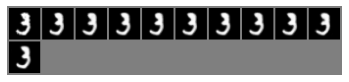

In [8]:
pgd.sample_image_posterior(10, N_PARTICLES)

# Inpainting

Calling `{PGD , VI, AlternatingBackprop, ShortRun}.reconstruct(img, mask=None)` will return the reconstruction of `img`. If `mask` is not `None`, then a partially occluded image is passed in and the result can be used to impute the missing pixels specified by the `mask`.

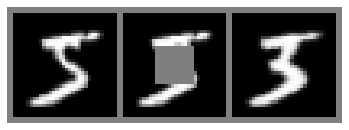

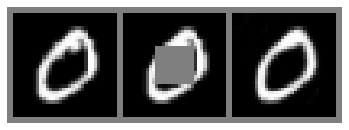

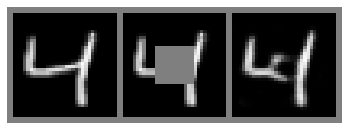

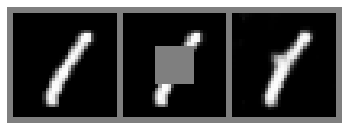

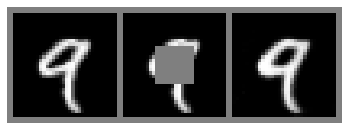

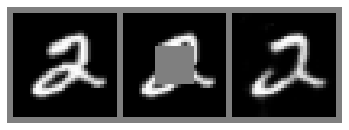

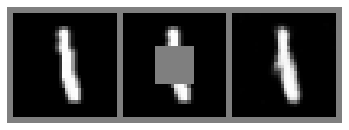

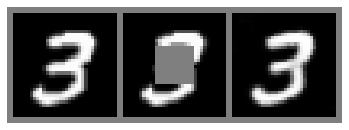

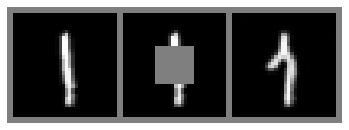

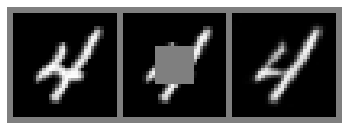

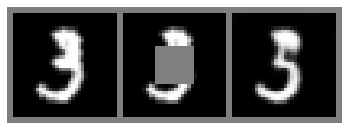

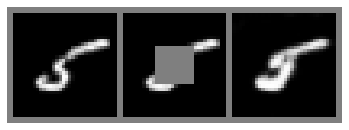

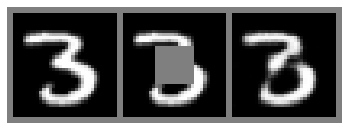

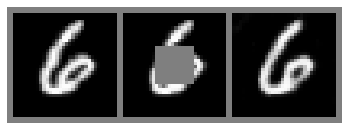

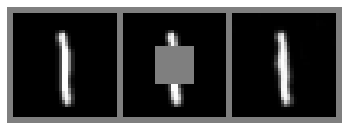

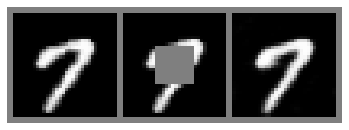

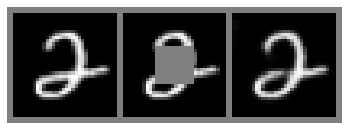

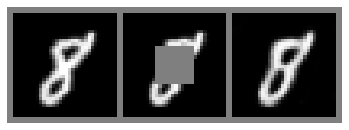

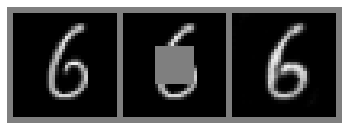

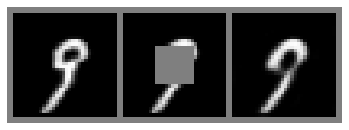

In [9]:
n_missing_img = 20
images = mnist[:n_missing_img][0]
mask = torch.ones(mnist.height, mnist.width, dtype=torch.bool)

for i in range(10, 22):
    for j in range(10, 22):
        mask[i, j] = False

_ = pgd.reconstruct(images, mask)

# Generate synthetic samples

Generate samples from the model using `{PGD , VI, AlternatingBackprop, ShortRun}.synthesize_images(...)`. The optional argument `approx_type` specifies the approximation used on the posterior. If
* `approx_type` is `gmm`. A Gaussian Mixture distribution is used, and `n_components` option specifies the number of components.
* `approx_type` is `gaussian`. A Gaussian distribution is used.
* `approx_type` is `gaussian_mixture_labels`. A Gaussian distribution is fitted to each class label.

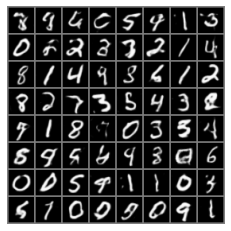

In [10]:
_ = pgd.synthesize_images(n=64, approx_type='gmm', n_components=100)